In [8]:
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('talk')
from pycorn import pc_res3, pc_uni6
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.signal import find_peaks
import os
from datetime import date
today = date.today().strftime("%Y%m%d")[2:]
print(today)

250312


### Gaussian functions (for fitting)

In [2]:
def Gaussians(x, Amp, Mean, Sigma):
    '''
    Arbitrary sum of gaussian funtions.
    Amp: vector of amplitude values
    Mean: vector of mean values
    Sigma: vector of sigma values
    Amp, Mean and Sigma must have the same length
    '''
    sum_fnc = []
    for pt in x:
        sum_fnc.append(np.array(Amp) * np.exp(-((pt-np.array(Mean))**2)/(2*np.array(Sigma)**2)))
    
    return np.sum(sum_fnc, axis=1)


def gaussian(x, a1, b1, c1):
    '''
    Single Gaussian function (1 kernel).
    '''
    
    return a1*np.exp((-(x-b1)**2)/(2*c1**2)) 

def gaussians6(x, 
               a1, a2, a3, a4, a5, a6, 
               b1, b2, b3, b4, b5, b6, 
               c1, c2, c3, c4, c5, c6):
    '''
    Explicit mixed Gaussian function (5 kernels).
    '''
    
    return ( a1*np.exp((-(x-b1)**2)/(2*c1**2)) + 
           a2*np.exp((-(x-b2)**2)/(2*c2**2)) + 
           a3*np.exp((-(x-b3)**2)/(2*c3**2)) + 
           a4*np.exp((-(x-b4)**2)/(2*c4**2)) + 
           a5*np.exp((-(x-b5)**2)/(2*c5**2))  + 
           a6*np.exp((-(x-b6)**2)/(2*c6**2))
           )        

def gaussians(x, a1, a2, a3, a4, a5, b1, b2, b3, b4, b5, c1, c2, c3, c4, c5):
    '''
    Explicit mixed Gaussian function (5 kernels).
    '''
    
    return a1*np.exp((-(x-b1)**2)/(2*c1**2)) + a2*np.exp((-(x-b2)**2)/(2*c2**2)) + a3*np.exp((-(x-b3)**2)/(2*c3**2)) + a4*np.exp((-(x-b4)**2)/(2*c4**2)) + a5*np.exp((-(x-b5)**2)/(2*c5**2)) 

### AKTA Calibrations

In [3]:
def S75_calibration(chroma):
    '''
    chroma: folder path containing the blue-dextran and protein injections
    '''
    
    hmw_std = {
        'Conalbumin':75000,
        'Ovalbumin':43000,
        'Carbonic anhydrase':29000,
        'Ribonuclease A':13700,
        'Aprotinin':6500
    }

    # Dextran injection
    dextran = pc_uni6(glob.glob(f'{chroma}*001.zip')[0])
    dextran.load()
    dextran.xml_parse()
    dextran.clean_up()
    v_dex, uv_dex = np.array(dextran['UV 1_280']['data']).T
    void = v_dex[np.argmax(uv_dex)]
    
    # Proteins injections
    proteins = pc_uni6(glob.glob(f'{chroma}*002.zip')[0])
    proteins.load()
    proteins.xml_parse()
    proteins.clean_up()
    v_prot, uv_prot = np.array(proteins['UV 1_280']['data']).T

    # Get peaks by fitting to Gaussian functions
#     popt, pcov = curve_fit(gaussians, v_prot, uv_prot, p0=np.array([np.array([50]*5), np.array([10,11,14,15,16]), np.array([1]*5)]))
#     peaks = popt[5:10]

    # Get peaks using scipy's find_peak method
    peak_idx, _ = find_peaks(uv_prot, height=10)
    peaks = v_prot[peak_idx]
    print(peaks)
    
    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].plot(v_dex, uv_dex, label='Dextran')
    ax[0].plot(v_prot, uv_prot, 'k-', label='Proteins')
#     ax[0].plot(v_prot, gaussians(v_prot, *popt), 'r--', label='Fit')
    ax[0].scatter(v_prot[peak_idx], uv_prot[peak_idx], edgecolor='black', color='white')
    ax[0].set(xlim=[7,20])
    ax[0].legend(loc='best')
    ax[0].set(xlabel='Retention volume / mL', ylabel='A280 / a.u.', title=chroma.split('/')[-2])

    # Calibration curve
    Kav = (peaks - void) / (24-void)
    log10mw = np.log10(list(hmw_std.values()))
    slope, intercept, rvalue, pvalue, stderr = linregress(log10mw, Kav)
    xs = np.linspace(log10mw.min(), log10mw.max(), 100)
    
    
    ax[1].scatter(log10mw, Kav, edgecolor='k', color='white')
    ax[1].plot(xs, intercept + slope*xs, 'k-', linewidth=1, label=f'$R^2$ = {rvalue**2:.3f}')
    ax[1].legend(loc='best')
    ax[1].set(xlabel='log10(MW)', ylabel='Kav', title=chroma.split('/')[-2])
    plt.tight_layout()
    plt.savefig('calibrations/' + chroma.split('/')[-2] + '.png', dpi=300)
    plt.show()

    # Save calibration data.
    calibration_data = {
        'log10mw':log10mw.tolist(),
        'Kav':Kav.tolist(),
        'Vc':24,
        'Vo':void,
        'intercept':intercept,
        'slope':slope
    }
    
    with open('calibrations/' + chroma.split('/')[-2] + '.json', 'w') as f:
        json.dump(calibration_data, f)

In [4]:
def S200_calibration(chroma):
    '''
    chroma: folder path containing the blue-dextran and protein injections
    '''
    
    hmw_std = {
        'Thyroglobulin':669000,
        'Ferritin':440000,
        'Aldolase':158000,
        'Conalbumin':75000,
        'Ovalbumin':43000,
    }

    # Dextran injection
    dextran = pc_uni6(glob.glob(f'{chroma}*001.zip')[0])
    dextran.load()
    dextran.xml_parse()
    dextran.clean_up()
    v_dex, uv_dex = np.array(dextran['UV 1_280']['data']).T
    void = v_dex[np.argmax(uv_dex)]
    
    # Proteins injections
    proteins = pc_uni6(glob.glob(f'{chroma}*002.zip')[0])
    proteins.load()
    proteins.xml_parse()
    proteins.clean_up()
    v_prot, uv_prot = np.array(proteins['UV 1_280']['data']).T

    # Get peaks by fitting to Gaussian functions
    popt, pcov = curve_fit(gaussians, 
                           v_prot, 
                           uv_prot, 
                           p0=np.hstack([np.array([50]*5), np.array([10,11,14,15,16]), np.array([1]*5)]),
                              bounds=np.array([[0.1, 100],
                                              [0.1, 500],
                                              [0.1, 500],
                                              [0.1, 500],
                                              [0.1, 500],
                                              [7, 20],
                                              [7, 20],
                                              [7, 20],
                                              [7, 20],
                                              [7, 20],
                                              [1e-3, 10],
                                              [1e-3, 10],
                                              [1e-3, 10],
                                              [1e-3, 10],
                                              [1e-3, 10]]).T)
    
    peaks = popt[5:10]

    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].plot(v_dex, uv_dex, label='Dextran')
    ax[0].plot(v_prot, uv_prot, 'k-', label='Proteins')
    ax[0].plot(v_prot, gaussians(v_prot, *popt), 'r-', linewidth=1, label='Fit')
     
    for i in range(5):
        print(popt[i::5])
        ax[0].fill_between(v_prot, gaussian(v_prot, *popt[i::5]), color='r', alpha=0.2)
    
    ax[0].set(xlim=[7,20])
    ax[0].legend(loc='best')
    ax[0].set(xlabel='Retention volume / mL', ylabel='A280 / a.u.', title=chroma.split('/')[-2])

    # Calibration curve
    Kav = (peaks - void) / (24-void)
    log10mw = np.log10(list(hmw_std.values()))
    slope, intercept, rvalue, pvalue, stderr = linregress(log10mw, Kav)
    xs = np.linspace(log10mw.min(), log10mw.max(), 100)
    
    
    ax[1].scatter(log10mw, Kav, color='white', edgecolor='k')
    ax[1].plot(xs, intercept + slope*xs, 'k-', linewidth=1, label=f'$R^2$ = {rvalue**2:.3f}')
    ax[1].legend(loc='best')
    ax[1].set(xlabel='log10(MW)', ylabel='Kav', title=chroma.split('/')[-2])
    plt.tight_layout()
    plt.savefig('calibrations/' + chroma.split('/')[-2] + '.png', dpi=300)
    plt.show()

    # Save calibration data.
    calibration_data = {
        'log10mw':log10mw.tolist(),
        'Kav':Kav.tolist(),
        'Vc':24,
        'Vo':void,
        'intercept':intercept,
        'slope':slope
    }
    
    with open('calibrations/' + chroma.split('/')[-2] + '.json', 'w') as f:
        json.dump(calibration_data, f)

### AKTA mini Calibrations

In [5]:
def S75mini_calibration(chroma):
    '''
    chroma: folder path containing the blue-dextran and protein injections
    '''
    
    hmw_std = {
        'Conalbumin':75000,
        'Ovalbumin':43000,
        'Carbonic anhydrase':29000,
        'Ribonuclease A':13700,
        'Aprotinin':6500
    }

    # Dextran injection
    dextran = pc_uni6(glob.glob(f'{chroma}*003.zip')[0])
    dextran.load()
    dextran.xml_parse()
    dextran.clean_up()
    v_dex, uv_dex = np.array(dextran['UV 1_280']['data']).T
    void = v_dex[np.argmax(uv_dex)]

    
    # Proteins injection
    proteins = pc_uni6(glob.glob(f'{chroma}*004.zip')[0])
    proteins.load()
    proteins.xml_parse()
    proteins.clean_up()
    v_prot, uv_prot = np.array(proteins['UV 1_280']['data']).T

    # Get peaks by fitting to Gaussian functions
    popt, pcov = curve_fit(gaussians, 
                           v_prot, 
                           uv_prot, 
                           p0=np.hstack([np.array([50]*5), np.array([1.2, 1.31, 1.64, 1.80, 2.0]), np.array([0.01]*5)]),
                           bounds=np.array([[0, 100],
                                          [0, 100],
                                          [0, 100],
                                          [0, 100],
                                          [0, 100],
                                          [1.2, 3],
                                          [1.2, 3],
                                          [1, 3],
                                          [1, 3],
                                          [1, 3],
                                          [1e-3, 1e-1],
                                          [1e-3, 1e-1],
                                          [1e-3, 1e-1],
                                          [1e-3, 1e-1],
                                          [1e-3, 1e-1]]).T)
    
    peaks = popt[5:10]

    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].plot(v_dex, uv_dex, label='Dextran')
    ax[0].plot(v_prot, uv_prot, 'k-', label='Proteins')
    ax[0].plot(v_prot, gaussians(v_prot, *popt), 'r-', linewidth=1, label='Fit')
    
    for i in range(5):
        ax[0].fill_between(v_prot, gaussian(v_prot, *popt[i::5]), color='r', alpha=0.2)
    
    ax[0].set(xlim=[0.8,2.5])
    ax[0].legend(loc='best')
    ax[0].set(xlabel='Retention volume / mL', ylabel='A280 / a.u.', title=chroma.split('/')[-2])

    for peak in peaks:
        ax[0].axvline(x=peak, color='gray', zorder=-10, alpha=0.5)
        ax[0].text(peak, 1.2*np.max(uv_prot), f"{peak:2.2f} mL", ha="left", va="center", rotation=60, fontsize=10)
    
    # Calibration curve
    Kav = (peaks - void) / (3-void)
    log10mw = np.log10(list(hmw_std.values()))
    slope, intercept, rvalue, pvalue, stderr = linregress(log10mw, Kav)
    xs = np.linspace(log10mw.min(), log10mw.max(), 100)
    
    ax[1].scatter(log10mw, Kav, color='white', edgecolor='k')
    ax[1].plot(xs, intercept + slope*xs, 'k-', linewidth=1, label=f'$R^2$ = {rvalue**2:.3f}')
    ax[1].legend(loc='best')
    ax[1].set(xlabel='log10(MW)', ylabel='Kav', title=chroma.split('/')[-2])
    plt.tight_layout()
    plt.savefig('calibrations/' + chroma.split('/')[-2] + '.png', dpi=300)
    plt.show()
    
    # Save calibration data.
    calibration_data = {
        'log10mw':log10mw.tolist(),
        'Kav':Kav.tolist(),
        'Vc':3,
        'Vo':void,
        'intercept':intercept,
        'slope':slope
    }
    
    with open('calibrations/' + chroma.split('/')[-2] + '.json', 'w') as f:
        json.dump(calibration_data, f)

In [6]:
def S200mini_calibration(chroma):
    '''
    chroma: folder path containing the blue-dextran and protein injections
    '''
    
    hmw_std = {
        'Thyroglobulin':669000,
        'Ferritin':440000,
        'Aldolase':158000,
        'Conalbumin':75000,
        'Ovalbumin':43000,
    }

    # Dextran injection
    dextran = pc_uni6(glob.glob(f'{chroma}*001.zip')[0])
    dextran.load()
    dextran.xml_parse()
    dextran.clean_up()
    v_dex, uv_dex = np.array(dextran['UV 1_280']['data']).T
    void = v_dex[np.argmax(uv_dex)]

    
    # Proteins injection
    proteins = pc_uni6(glob.glob(f'{chroma}*002.zip')[0])
    proteins.load()
    proteins.xml_parse()
    proteins.clean_up()
    v_prot, uv_prot = np.array(proteins['UV 1_280']['data']).T

    # Get peaks by fitting to Gaussian functions
    popt, pcov = curve_fit(gaussians, 
                           v_prot, 
                           uv_prot, 
                           p0=np.hstack([np.array([50]*5), np.array([1.1, 1.31, 1.64, 1.80, 2.0]), np.array([0.01]*5)]),
                           bounds=np.array([[0, 100],
                                          [0, 100],
                                          [0, 100],
                                          [0, 100],
                                          [0, 100],
                                          [1, 3],
                                          [1, 3],
                                          [1, 3],
                                          [1, 3],
                                          [1, 3],
                                          [1e-3, 1e-1],
                                          [1e-3, 1e-1],
                                          [1e-3, 1e-1],
                                          [1e-3, 1e-1],
                                          [1e-3, 1e-1]]).T)
    
    peaks = popt[5:10]

    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].plot(v_dex, uv_dex, label='Dextran')
    ax[0].plot(v_prot, uv_prot, 'k-', label='Proteins')
    ax[0].plot(v_prot, gaussians(v_prot, *popt), 'r-', linewidth=1, label='Fit')
    
    for i in range(5):
        ax[0].fill_between(v_prot, gaussian(v_prot, *popt[i::5]), color='r', alpha=0.2)
    
    ax[0].set(xlim=[0.8,2.5])
    ax[0].legend(loc='best')
    ax[0].set(xlabel='Retention volume / mL', ylabel='A280 / a.u.', title=chroma.split('/')[-2])
    
    # Calibration curve
    Kav = (peaks - void) / (3 - void)
    log10mw = np.log10(list(hmw_std.values()))
    slope, intercept, rvalue, pvalue, stderr = linregress(log10mw, Kav)
    xs = np.linspace(log10mw.min(), log10mw.max(), 100)
    
    ax[1].scatter(log10mw, Kav, color='white', edgecolor='k')
    ax[1].plot(xs, intercept + slope*xs, 'k-', linewidth=1, label=f'$R^2$ = {rvalue**2:.3f}')
    ax[1].legend(loc='best')
    ax[1].set(xlabel='log10(MW)', ylabel='Kav', title=chroma.split('/')[-2])
    plt.tight_layout()
    plt.savefig('calibrations/' + chroma.split('/')[-2] + '.png', dpi=300)
    plt.show()

    # Save calibration data.
    calibration_data = {
        'log10mw':log10mw.tolist(),
        'Kav':Kav.tolist(),
        'Vc':3,
        'Vo':void,
        'intercept':intercept,
        'slope':slope
    }
    
    with open('calibrations/' + chroma.split('/')[-2] + '.json', 'w') as f:
        json.dump(calibration_data, f)
    

In [8]:
def S200mini_calibration_fitvoid(chroma, no_dextran, no_calib ):
    '''
    chroma: folder path containing the blue-dextran and protein injections
    '''
    
    hmw_std = {
        'Thyroglobulin':669000,
        'Ferritin':440000,
        'Aldolase':158000,
        'Conalbumin':75000,
        'Ovalbumin':43000,
    }

    # Dextran injection
    dextran = pc_uni6(glob.glob(f'{chroma}*{no_dextran}.zip')[0])
    dextran.load()
    dextran.xml_parse()
    dextran.clean_up()
    v_dex, uv_dex = np.array(dextran['UV 1_280']['data']).T
    void = v_dex[np.argmax(uv_dex)]

    
    # Proteins injection
    proteins = pc_uni6(glob.glob(f'{chroma}*{no_calib}.zip')[0])
    proteins.load()
    proteins.xml_parse()
    proteins.clean_up()
    v_prot, uv_prot = np.array(proteins['UV 1_280']['data']).T

    # Get peaks by fitting to Gaussian functions
    peak_pos_guess = np.array([1.1, #void peak 
                               1.25, 1.35, 1.64, 1.80, 2.0])
    bounds = np.array( 
                       [ [0,100], ] *len(peak_pos_guess) +
                       [ [1.1,3], ] *len(peak_pos_guess) +
                       [ [1e-3, 1e-1], ] *len(peak_pos_guess) ,
                         ).T
    p0 = np.hstack([np.array([50]*len(peak_pos_guess) ), np.array(peak_pos_guess) , np.array([0.01]*len(peak_pos_guess) )])
    print(p0.shape)
    print(bounds.shape)
    
    popt, pcov = curve_fit(gaussians6, 
                           v_prot, 
                           uv_prot, 
                           p0=p0,
                           bounds=bounds ,
                          )
    #remove void peak
    # peaks = popt[5:10]
    print(popt)
    peaks = popt[len(peak_pos_guess)+1:len(peak_pos_guess)+len(peak_pos_guess)]
    print(peaks)

    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].plot(v_dex, uv_dex, label='Dextran')
    ax[0].plot(v_prot, uv_prot, 'k-', label='Proteins')
    ax[0].plot(v_prot, gaussians6(v_prot, *popt), 'r-', linewidth=1, label='Fit')
    
    for i in range(len(peak_pos_guess)):
        color='r'
        if i == 0:
            color='gray'
        ax[0].fill_between(v_prot, gaussian(v_prot, *popt[i::len(peak_pos_guess)]), color=color, alpha=0.2)

        
    
    ax[0].set(xlim=[0.8,2.5])
    ax[0].legend(loc='best')
    ax[0].set(xlabel='Retention volume / mL', ylabel='A280 / a.u.', title=chroma.split('/')[-2])

    
    # Calibration curve
    Kav = (peaks - void) / (3-void)
    log10mw = np.log10(list(hmw_std.values()))
    slope, intercept, rvalue, pvalue, stderr = linregress(log10mw, Kav)
    xs = np.linspace(log10mw.min(), log10mw.max(), 100)
    
    for peak in peaks:
        ax[0].axvline(x=peak, color='gray', zorder=-10, alpha=0.5)
        ax[0].text(peak, 1.2*np.max(uv_prot), f"{peak:2.2f} mL", ha="left", va="center", rotation=60, fontsize=10)
    
    ax[1].scatter(log10mw, Kav, color='white', edgecolor='k')
    ax[1].plot(xs, intercept + slope*xs, 'k-', linewidth=1, label=f'$R^2$ = {rvalue**2:.3f}')
    ax[1].legend(loc='best')
    ax[1].set(xlabel='log10(MW)', ylabel='Kav', title=chroma.split('/')[-2])
    plt.tight_layout()
    plt.savefig('calibrations/' + chroma.split('/')[-2] + f'_excl_void_{no_calib}.png', dpi=300)
    plt.show()
    
    # Save calibration data.
    calibration_data = {
        'log10mw':log10mw.tolist(),
        'Kav':Kav.tolist(),
        'Vc':3,
        'Vo':void,
        'intercept':intercept,
        'slope':slope
    }
    
    with open('calibrations/' + chroma.split('/')[-2] + f'_excl_void_S200mini_{no_calib}.json', 'w') as f:
        json.dump(calibration_data, f)


def S75mini_calibration_fitvoid(chroma, no_dextran, no_calib ):
    '''
    chroma: folder path containing the blue-dextran and protein injections
    '''
    
    hmw_std = {
        'Conalbumin':75000,
        'Ovalbumin':43000,
        'Carbonic anhydrase':29000,
        'Ribonuclease A':13700,
        'Aprotinin':6500
    }

    # Dextran injection
    dextran = pc_uni6(glob.glob(f'{chroma}*{no_dextran}.zip')[0])
    dextran.load()
    dextran.xml_parse()
    dextran.clean_up()
    v_dex, uv_dex = np.array(dextran['UV 1_280']['data']).T
    void = v_dex[np.argmax(uv_dex)]

    
    # Proteins injection
    proteins = pc_uni6(glob.glob(f'{chroma}*{no_calib}.zip')[0])
    proteins.load()
    proteins.xml_parse()
    proteins.clean_up()
    v_prot, uv_prot = np.array(proteins['UV 1_280']['data']).T

    # Get peaks by fitting to Gaussian functions
    peak_pos_guess = np.array([1.1, #void peak 
                               1.25, 1.35, 1.64, 1.80, 2.0])
    bounds = np.array( 
                       [ [0,100], ] *len(peak_pos_guess) +
                       [ [1.1,3], ] *len(peak_pos_guess) +
                       [ [1e-3, 1e-1], ] *len(peak_pos_guess) ,
                         ).T
    p0 = np.hstack([np.array([50]*len(peak_pos_guess) ), np.array(peak_pos_guess) , np.array([0.01]*len(peak_pos_guess) )])
    print(p0.shape)
    print(bounds.shape)
    
    popt, pcov = curve_fit(gaussians6, 
                           v_prot, 
                           uv_prot, 
                           p0=p0,
                           bounds=bounds ,
                          )
    #remove void peak
    # peaks = popt[5:10]
    print(popt)
    peaks = popt[len(peak_pos_guess)+1:len(peak_pos_guess)+len(peak_pos_guess)]
    print(peaks)

    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].plot(v_dex, uv_dex, label='Dextran')
    ax[0].plot(v_prot, uv_prot, 'k-', label='Proteins')
    ax[0].plot(v_prot, gaussians6(v_prot, *popt), 'r-', linewidth=1, label='Fit')
    
    for i in range(len(peak_pos_guess)):
        color='r'
        if i == 0:
            color='gray'
        ax[0].fill_between(v_prot, gaussian(v_prot, *popt[i::len(peak_pos_guess)]), color=color, alpha=0.2)

        
    
    ax[0].set(xlim=[0.8,2.5])
    ax[0].legend(loc='best')
    ax[0].set(xlabel='Retention volume / mL', ylabel='A280 / a.u.', title=chroma.split('/')[-2])

    
    # Calibration curve
    Kav = (peaks - void) / (3-void)
    log10mw = np.log10(list(hmw_std.values()))
    slope, intercept, rvalue, pvalue, stderr = linregress(log10mw, Kav)
    xs = np.linspace(log10mw.min(), log10mw.max(), 100)
    
    for peak in peaks:
        ax[0].axvline(x=peak, color='gray', zorder=-10, alpha=0.5)
        ax[0].text(peak, 1.2*np.max(uv_prot), f"{peak:2.2f} mL", ha="left", va="center", rotation=60, fontsize=10)
    
    ax[1].scatter(log10mw, Kav, color='white', edgecolor='k')
    ax[1].plot(xs, intercept + slope*xs, 'k-', linewidth=1, label=f'$R^2$ = {rvalue**2:.3f}')
    ax[1].legend(loc='best')
    ax[1].set(xlabel='log10(MW)', ylabel='Kav', title=chroma.split('/')[-2])
    plt.tight_layout()
    plt.savefig('calibrations/' + chroma.split('/')[-2] + f'_excl_void_{no_calib}.png', dpi=300)
    plt.show()
    
    # Save calibration data.
    calibration_data = {
        'log10mw':log10mw.tolist(),
        'Kav':Kav.tolist(),
        'Vc':3,
        'Vo':void,
        'intercept':intercept,
        'slope':slope
    }
    
    with open('calibrations/' + chroma.split('/')[-2] + f'_excl_void_{no_calib}.json', 'w') as f:
        json.dump(calibration_data, f)


#new s75mini from Dec12 2022
# S75mini_calibration('/home/lmilles/3expdata/SEC/2022_12_12_cal_S75mini_new_NaP100/', "003", "004")
# S75mini_calibration_fitvoid('/home/lmilles/3expdata/SEC/2022_12_12_cal_S75mini_new_NaP100/', "003", "004")


# S75mini_calibration_fitvoid('/home/lmilles/3expdata/SEC/2023_02_16_LMWcal50uL_S75mini_NaP100/', "001", "002" )
# S75mini_calibration_fitvoid('/home/lmilles/3expdata/SEC/2023_02_16_LMWcal50uL_S75mini_NaP100/', "125", "126" )



### HPLC Calibrations

In [22]:
def S75mini_calibration_agilent_fitvoid(path_dextran, path_calib, flowrate, comment="" ):
    '''
    chroma: folder path containing the blue-dextran and protein injections
    '''
    
    savename = 'calibrations/' + "HAL9000_" + dex.split('/')[-1].replace(".CSV", "").replace(" ", "_") + "_" + comment
    
    hmw_std = {
        'Conalbumin':75000,
        'Ovalbumin':43000,
        'Carbonic anhydrase':29000,
        'Ribonuclease A':13700,
        'Aprotinin':6500
    }

    dextran = np.loadtxt(path_dextran, delimiter=",")
    dextran[:,0] = dextran[:,0] * flowrate

    v_dex, uv_dex = dextran[:,0] , dextran[:,1]
    void = v_dex[np.argmax(uv_dex)]

    print ( f"VOID: {void:1.3f} mL")

    proteins = np.loadtxt(path_calib, delimiter=",")
    proteins[:,0] = proteins[:,0] * flowrate
    v_prot, uv_prot = proteins[:,0], proteins[:,1]


    # Get peaks by fitting to Gaussian functions
    peak_pos_guess = np.array([void*0.95, #void peak 
                               1.22892861 , 1.33212932, 1.54220434, 1.78828965, 2.12824897,
                               #1.25, 1.35, 1.6, 1.80, 2.15
                              ])
    bounds = np.array( 
                       [ [0, 1100], ]   *len(peak_pos_guess) +     #scale
                       [ [1.0,2.6], ]   *len(peak_pos_guess) +     # mean
                       [ [1e-5, 1.0e-1], ] *len(peak_pos_guess) ,     # std
                         ).T
    p0 = np.hstack([np.array([50]*len(peak_pos_guess) ), np.array(peak_pos_guess) , np.array([0.01]*len(peak_pos_guess) )])
    print(p0.shape)
    print(bounds.shape)
    
    # popt= p0
    popt, pcov = curve_fit(gaussians6, 
                           v_prot, 
                           uv_prot, 
                           p0=p0,
                           bounds=bounds ,
                           # maxfev=1e6
                          )
 #    popt = [1.26517452e+02 ,5.04075172e+02, 5.99687981e+02, 2.83442026e+02,
 # 4.16019723e+02, 3.62879603e+02, 1.11775545e+00 ,1.22566036e+00,
 # 1.33943519e+00, 1.53629833e+00 ,1.78834227e+00 ,2.09254408e+00,
 # 4.08184419e-02, 4.26238299e-02 ,6.22584807e-02, 5.47710286e-02,
 # 5.06132447e-02, 5.60566319e-02,]
    
    print(popt)
    peaks = popt[len(peak_pos_guess)+1:len(peak_pos_guess)+len(peak_pos_guess)]
    print(peaks)
    

    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].plot(v_dex, uv_dex, label='Dextran')
    ax[0].plot(v_prot, uv_prot, 'k-', label='Proteins')
    ax[0].plot(v_prot, gaussians6(v_prot, *popt), 'r-', linewidth=1, label='Fit')
    
    for i in range(len(peak_pos_guess)):
        color='r'
        if i == 0:
            color='gray'
        ax[0].fill_between(v_prot, gaussian(v_prot, *popt[i::len(peak_pos_guess)]), color=color, alpha=0.2)

        
    
    ax[0].set(xlim=[0.8,2.5])
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5) )#loc='best')
    ax[0].set(xlabel='Retention volume / mL', ylabel='A280 / a.u.',)# title=chroma.split('/')[-2])

    
    # Calibration curve
    Kav = (peaks - void) / (3-void)
    log10mw = np.log10(list(hmw_std.values()))
    slope, intercept, rvalue, pvalue, stderr = linregress(log10mw, Kav)
    xs = np.linspace(log10mw.min(), log10mw.max(), 100)
    
    for peak in peaks:
        ax[0].axvline(x=peak, color='gray', zorder=-10, alpha=0.5)
        ax[0].text(peak, 1.2*np.max(uv_prot), f"{peak:2.2f} mL", ha="left", va="center", rotation=60, fontsize=10)
    
    ax[0].axvline(x=void, color='k', zorder=-10, alpha=0.8)
    ax[0].text(void, 1.2*np.max(uv_prot), f"Void\n{void:2.2f} mL", ha="right", va="center", rotation=60, fontsize=10)
    
    ax[0].set_ylim( [-1.0, 1.2 * np.max(uv_prot) ] )


    ax[1].scatter(log10mw, Kav, color='white', edgecolor='k')
    ax[1].plot(xs, intercept + slope*xs, 'k-', linewidth=1, label=f'$R^2$ = {rvalue**2:.3f}')
    ax[1].legend(loc='best' ) #loc='best',
    ax[1].set(xlabel='log10(MW)', ylabel='Kav',)# title=chroma.split('/')[-2])
    plt.tight_layout()
    plt.savefig(savename + '.png', dpi=300)
    plt.show()
    
    # Save calibration data.
    calibration_data = {
        'log10mw':log10mw.tolist(),
        'Kav':Kav.tolist(),
        'Vc':3,
        'Vo':void,
        'intercept':intercept,
        'slope':slope
    }
    
    print("saving to: " , os.path.abspath ( savename + f'_excl_void_agilent.json' )  )
    with open(savename + f'_excl_void_agilent.json' , 'w') as f:
        json.dump(calibration_data, f)

def S200mini_calibration_agilent_fitvoid(path_dextran, path_calib, flowrate, comment="" ):
    '''
    chroma: folder path containing the blue-dextran and protein injections
    '''
    
    savename = dex.split('/')[-1].replace(".CSV", "").replace(" ", "_") + "_" + comment
    
    hmw_std = {
        'Thyroglobulin':669000,
        'Ferritin':440000,
        'Aldolase':158000,
        'Conalbumin':75000,
        'Ovalbumin':43000,
    }


    dextran = np.loadtxt(path_dextran, delimiter=",")
    dextran[:,0] = dextran[:,0] * flowrate

    v_dex, uv_dex = dextran[:,0] , dextran[:,1]
    void = v_dex[np.argmax(uv_dex)]


    
    print ( f"VOID: {void:1.3f} mL")

    proteins = np.loadtxt(path_calib, delimiter=",")
    proteins[:,0] = proteins[:,0] * flowrate
    v_prot, uv_prot = proteins[:,0], proteins[:,1]

    # plt.plot(dextran[:,0], dextran[:,1])
    # plt.plot(proteins[:,0], proteins[:,1])
    # plt.show()

    # Get peaks by fitting to Gaussian functions
    peak_pos_guess = np.array([void*0.95, #void peak 
                               1.22892861 , 1.33212932, 1.54220434, 1.78828965, 2.12824897,
                               #1.25, 1.35, 1.6, 1.80, 2.15
                              ])
    bounds = np.array( 
                       [ [0, 1100], ]   *len(peak_pos_guess) +     #scale
                       [ [1.0,2.6], ]   *len(peak_pos_guess) +     # mean
                       [ [1e-5, 1.0e-1], ] *len(peak_pos_guess) ,     # std
                         ).T
    p0 = np.hstack([np.array([50]*len(peak_pos_guess) ), np.array(peak_pos_guess) , np.array([0.01]*len(peak_pos_guess) )])
    print(p0.shape)
    print(bounds.shape)
    
    # popt= p0
    popt, pcov = curve_fit(gaussians6, 
                           v_prot, 
                           uv_prot, 
                           p0=p0,
                           bounds=bounds ,
                           # maxfev=1e6
                          )
    print(popt)
    peaks = popt[len(peak_pos_guess)+1:len(peak_pos_guess)+len(peak_pos_guess)]
    print(peaks)
    

    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].plot(v_dex, uv_dex, label='Dextran')
    ax[0].plot(v_prot, uv_prot, 'k-', label='Proteins')
    ax[0].plot(v_prot, gaussians6(v_prot, *popt), 'r-', linewidth=1, label='Fit')
    
    for i in range(len(peak_pos_guess)):
        color='r'
        if i == 0:
            color='gray'
        ax[0].fill_between(v_prot, gaussian(v_prot, *popt[i::len(peak_pos_guess)]), color=color, alpha=0.2)

        
    
    ax[0].set(xlim=[0.8,2.5])
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5) )#loc='best')
    ax[0].set(xlabel='Retention volume / mL', ylabel='A280 / a.u.',)# title=chroma.split('/')[-2])

    
    # Calibration curve
    Kav = (peaks - void) / (3-void)
    log10mw = np.log10(list(hmw_std.values()))
    slope, intercept, rvalue, pvalue, stderr = linregress(log10mw, Kav)
    xs = np.linspace(log10mw.min(), log10mw.max(), 100)
    
    for peak in peaks:
        ax[0].axvline(x=peak, color='gray', zorder=-10, alpha=0.5)
        ax[0].text(peak, 1.2*np.max(uv_prot), f"{peak:2.2f} mL", ha="left", va="center", rotation=60, fontsize=10)
    
    ax[0].axvline(x=void, color='k', zorder=-10, alpha=0.8)
    ax[0].text(void, 1.2*np.max(uv_prot), f"Void\n{void:2.2f} mL", ha="right", va="center", rotation=60, fontsize=10)
    
    ax[0].set_ylim( [-1.0, 1.5 * np.max(uv_prot) ] )


    ax[1].scatter(log10mw, Kav, color='white', edgecolor='k')
    ax[1].plot(xs, intercept + slope*xs, 'k-', linewidth=1, label=f'$R^2$ = {rvalue**2:.3f}')
    ax[1].legend(loc='best' ) #loc='best',
    ax[1].set(xlabel='log10(MW)', ylabel='Kav',)# title=chroma.split('/')[-2])
    #plt.set_title("S75 ")
    plt.tight_layout()
    plt.savefig(savename + '.png', dpi=300)
    plt.show()
    
    # Save calibration data.
    calibration_data = {
        'log10mw':log10mw.tolist(),
        'Kav':Kav.tolist(),
        'Vc':3,
        'Vo':void,
        'intercept':intercept,
        'slope':slope
    }
    
    print("saving to: " , os.path.abspath ( savename + f'_excl_void_agilent.json' )  )
    with open(savename + f'_excl_void_S200mini_agilent.json' , 'w') as f:
        json.dump(calibration_data, f)


def S200mini_calibration_agilent(path_dextran, path_calib, flowrate, comment="" ):
    '''
    chroma: folder path containing the blue-dextran and protein injections
    '''
    
    savename = 'calibrations/' + "HAL9000_" + dex.split('/')[-1].replace(".CSV", "").replace(" ", "_") + "_" + comment
    
    hmw_std = {
        'Thyroglobulin':669000,
        'Ferritin':440000,
        'Aldolase':158000,
        'Conalbumin':75000,
        'Ovalbumin':43000,
    }


    dextran = np.loadtxt(path_dextran, delimiter=",")
    dextran[:,0] = dextran[:,0] * flowrate

    v_dex, uv_dex = dextran[:,0] , dextran[:,1]
    void = v_dex[np.argmax(uv_dex)]


    
    print ( f"VOID: {void:1.3f} mL")

    proteins = np.loadtxt(path_calib, delimiter=",")
    proteins[:,0] = proteins[:,0] * flowrate
    v_prot, uv_prot = proteins[:,0], proteins[:,1]

    # plt.plot(dextran[:,0], dextran[:,1])
    # plt.plot(proteins[:,0], proteins[:,1])
    # plt.show()

    # Get peaks by fitting to Gaussian functions
    peak_pos_guess = np.array([#void*0.95, #void peak 
                               1.22892861 , 1.33212932, 1.54220434, 1.78828965, 2.12824897,
                               #1.25, 1.35, 1.6, 1.80, 2.15
                              ])
    bounds = np.array( 
                       [ [0, 1100], ]   *len(peak_pos_guess) +     #scale
                       [ [1.0,2.6], ]   *len(peak_pos_guess) +     # mean
                       [ [1e-5, 1.0e-1], ] *len(peak_pos_guess) ,     # std
                         ).T
    p0 = np.hstack([np.array([50]*len(peak_pos_guess) ), np.array(peak_pos_guess) , np.array([0.01]*len(peak_pos_guess) )])
    print(p0.shape)
    print(bounds.shape)
    
    # popt= p0
    popt, pcov = curve_fit(gaussians, 
                           v_prot, 
                           uv_prot, 
                           p0=p0,
                           bounds=bounds ,
                           # maxfev=1e6
                          )
    print(popt)
    peaks = popt[len(peak_pos_guess):len(peak_pos_guess)+len(peak_pos_guess)]
    print(peaks)
    

    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].plot(v_dex, uv_dex, label='Dextran')
    ax[0].plot(v_prot, uv_prot, 'k-', label='Proteins')
    ax[0].plot(v_prot, gaussians(v_prot, *popt), 'r-', linewidth=1, label='Fit')
    
    for i in range(len(peak_pos_guess)):
        color='r'
        # if i == 0:
        #     color='gray'
        ax[0].fill_between(v_prot, gaussian(v_prot, *popt[i::len(peak_pos_guess)]), color=color, alpha=0.2)

        
    
    ax[0].set(xlim=[0.8,2.5])
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5) )#loc='best')
    ax[0].set(xlabel='Retention volume / mL', ylabel='A280 / a.u.',)# title=chroma.split('/')[-2])

    
    # Calibration curve
    Kav = (peaks - void) / (3-void)
    log10mw = np.log10(list(hmw_std.values()))
    slope, intercept, rvalue, pvalue, stderr = linregress(log10mw, Kav)
    xs = np.linspace(log10mw.min(), log10mw.max(), 100)
    
    for peak in peaks:
        ax[0].axvline(x=peak, color='gray', zorder=-10, alpha=0.5)
        ax[0].text(peak, 1.2*np.max(uv_prot), f"{peak:2.2f} mL", ha="left", va="center", rotation=60, fontsize=10)
    
    ax[0].axvline(x=void, color='k', zorder=-10, alpha=0.8)
    ax[0].text(void, 1.2*np.max(uv_prot), f"Void\n{void:2.2f} mL", ha="right", va="center", rotation=60, fontsize=10)
    
    ax[0].set_ylim( [-1.0, 1.2 * np.max(uv_prot) ] )


    ax[1].scatter(log10mw, Kav, color='white', edgecolor='k')
    ax[1].plot(xs, intercept + slope*xs, 'k-', linewidth=1, label=f'$R^2$ = {rvalue**2:.3f}')
    ax[1].legend(loc='best' ) #loc='best',
    ax[1].set(xlabel='log10(MW)', ylabel='Kav',)# title=chroma.split('/')[-2])
    plt.tight_layout()
    plt.savefig(savename + '.png', dpi=300)
    print(savename + '.png')
    plt.show()
    
    # Save calibration data.
    calibration_data = {
        'log10mw':log10mw.tolist(),
        'Kav':Kav.tolist(),
        'Vc':3,
        'Vo':void,
        'intercept':intercept,
        'slope':slope
    }
    
    print("saving to: " , os.path.abspath ( savename + f'_S200mini_agilent.json' )  )
    with open(savename + f'_S200mini_agilent.json' , 'w') as f:
        json.dump(calibration_data, f)




In [19]:
def agilent_calibration_biorad_std_fitvoid(path_dextran, path_calib, flowrate, comment="" ):
    '''
    chroma: folder path containing the blue-dextran and protein injections
    '''
    savename = today + "_" + comment
    
    hmw_std = {
        'Thyroglobulin':670000,
        'g-globulin (bovine) ':158000,
        'Ovalbumin (chicken) ':44000,
        'Myoglobin (horse)':17000,
        'Cobalamin(vit b12)':1350,
    }


    dextran = np.loadtxt(path_dextran, delimiter=",")
    dextran[:,0] = dextran[:,0] * flowrate

    v_dex, uv_dex = dextran[:,0] , dextran[:,1]
    void = v_dex[np.argmax(uv_dex)]


    
    print ( f"VOID: {void:1.3f} mL")

    proteins = np.loadtxt(path_calib, delimiter=",")
    proteins[:,0] = proteins[:,0] * flowrate
    v_prot, uv_prot = proteins[:,0], proteins[:,1]

    # plt.plot(dextran[:,0], dextran[:,1])
    # plt.plot(proteins[:,0], proteins[:,1])
    # plt.show()

    # Get peaks by fitting to Gaussian functions
    peak_pos_guess = np.array([void*0.95, #void peak 
                               1.22892861 , 1.33212932, 1.54220434, 1.78828965, 2.12824897,
                               #1.25, 1.35, 1.6, 1.80, 2.15
                              ])
    bounds = np.array( 
                       [ [0, 1100], ]   *len(peak_pos_guess) +     #scale
                       [ [1.0,2.6], ]   *len(peak_pos_guess) +     # mean
                       [ [1e-5, 1.0e-1], ] *len(peak_pos_guess) ,     # std
                         ).T
    p0 = np.hstack([np.array([50]*len(peak_pos_guess) ), np.array(peak_pos_guess) , np.array([0.01]*len(peak_pos_guess) )])
    print(p0.shape)
    print(bounds.shape)
    
    # popt= p0
    popt, pcov = curve_fit(gaussians6, 
                           v_prot, 
                           uv_prot, 
                           p0=p0,
                           bounds=bounds ,
                           # maxfev=1e6
                          )
    print(popt)
    peaks = popt[len(peak_pos_guess)+1:len(peak_pos_guess)+len(peak_pos_guess)]
    print(peaks)
    

    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].plot(v_dex, uv_dex, label='Dextran')
    ax[0].plot(v_prot, uv_prot, 'k-', label='Proteins')
    ax[0].plot(v_prot, gaussians6(v_prot, *popt), 'r-', linewidth=1, label='Fit')
    
    for i in range(len(peak_pos_guess)):
        color='r'
        if i == 0:
            color='gray'
        ax[0].fill_between(v_prot, gaussian(v_prot, *popt[i::len(peak_pos_guess)]), color=color, alpha=0.2)

        
    
    ax[0].set(xlim=[0.8,3.0])
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5) )#loc='best')
    ax[0].set(xlabel='Retention volume / mL', ylabel='A280 / a.u.',)# title=chroma.split('/')[-2])

    
    # Calibration curve
    Kav = (peaks - void) / (3-void)
    log10mw = np.log10(list(hmw_std.values()))
    slope, intercept, rvalue, pvalue, stderr = linregress(log10mw, Kav)
    xs = np.linspace(log10mw.min(), log10mw.max(), 100)
    
    for peak in peaks:
        ax[0].axvline(x=peak, color='gray', zorder=-10, alpha=0.5)
        ax[0].text(peak, 1.2*np.max(uv_prot), f"{peak:2.2f} mL", ha="left", va="center", rotation=60, fontsize=10)
    
    ax[0].axvline(x=void, color='k', zorder=-10, alpha=0.8)
    ax[0].text(void, 1.2*np.max(uv_prot), f"Void\n{void:2.2f} mL", ha="right", va="center", rotation=60, fontsize=10)
    
    ax[0].set_ylim( [-1.0, 1.5 * np.max(uv_prot) ] )
    print(f'uv_prot max: {np.max(uv_prot[150:])}')

    ax[1].scatter(log10mw, Kav, color='white', edgecolor='k')
    ax[1].plot(xs, intercept + slope*xs, 'k-', linewidth=1, label=f'$R^2$ = {rvalue**2:.3f}')
    ax[1].legend(loc='best' ) #loc='best',
    ax[1].set(xlabel='log10(MW)', ylabel='Kav',)# title=chroma.split('/')[-2])
    #plt.set_title("S75 ")
    plt.tight_layout()
    plt.savefig(savename + '.png', dpi=300)
    plt.show()
    
    # Save calibration data.
    calibration_data = {
        'log10mw':log10mw.tolist(),
        'Kav':Kav.tolist(),
        'Vc':3,
        'Vo':void,
        'intercept':intercept,
        'slope':slope
    }
    
    print("saving to: " , os.path.abspath ( savename + f'_void_agilent.json' )  )
    with open(savename + f'_void_agilent.json' , 'w') as f:
        json.dump(calibration_data, f)

## Calibrations

VOID: 1.118 mL
(18,)
(2, 18)
[2.51498831e+02 2.17315026e+02 9.74846098e+01 1.07216441e+01
 2.43835742e+02 5.43614670e+02 2.41760459e+00 2.59200000e+00
 2.18886317e+00 1.27287108e+00 1.71667629e+00 2.21252761e+00
 9.71160023e-02 2.13566122e-05 1.09033636e-05 3.97582302e-05
 3.97628373e-02 7.48760535e-02]
[2.592      2.18886317 1.27287108 1.71667629 2.21252761]
uv_prot max: 784.460067749023


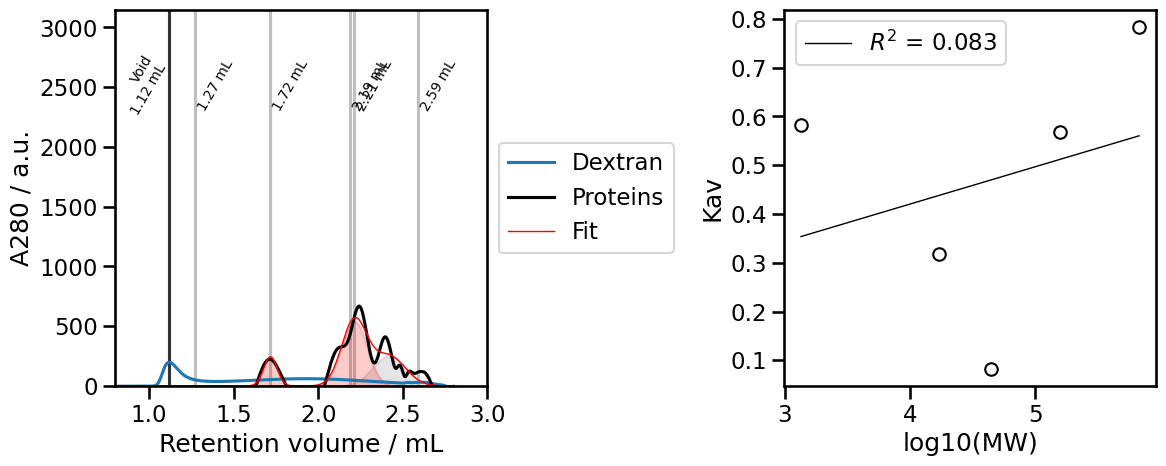

saving to:  /home/srgerb/scripts/cowboy/calibrations/250312_GLaDOS_S6_void_agilent.json


In [20]:
dex = '/home/srgerb/scripts/cowboy/calibrations/GLaDOS_calibration_s6/dextran/20250225 235454_29_dextran.dx_MWD1A.CSV'
prot = '/home/srgerb/scripts/cowboy/calibrations/GLaDOS_calibration_s6/prot_standards/20250225 234629_28_prot_standards.dx_MWD1C.CSV'
agilent_calibration_biorad_std_fitvoid(dex, prot, 0.35, comment="GLaDOS_S6" )

In [24]:
flowrate = .35
proteins = np.loadtxt(prot, delimiter=",")
proteins[:,0] = proteins[:,0] * flowrate
v_prot, uv_prot = proteins[:,0], proteins[:,1]

In [27]:
lower_bound = .79
upper_bound = .81
rng_void = np.where((v_prot >= lower_bound) & (v_prot <= upper_bound))
rn

(array([339, 340, 341, 342, 343, 344, 345, 346]),)

Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data
Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data
[74.55127184  9.64002729  0.47722985]
[98.48665702 11.07535358  0.48879042]
[61.92444786 13.34448033  0.44528689]
[42.09209875 14.6646686   0.23851328]
[85.10899234 15.31419142  0.70842645]


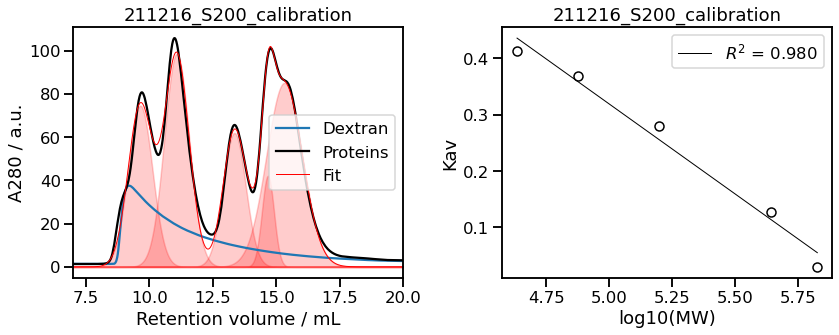

In [8]:
S200_calibration('/net/expdata/AKTA/Fanboy/Basile/211216_S200_calibration/')

Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data
Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data


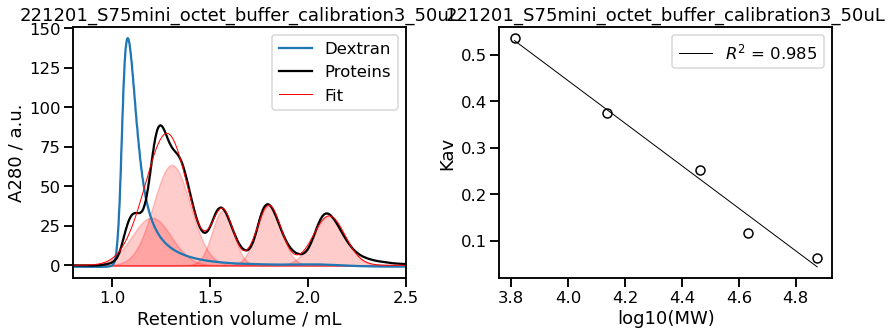

In [18]:
S75mini_calibration('/net/expdata/AKTA/Fanboy/Basile/221201_S75mini_octet_buffer_calibration3_50uL/')

In [30]:
def S75mini_calibration_agilent_fitvoid(path_dextran, path_calib, flowrate, comment="" ):
    '''
    chroma: folder path containing the blue-dextran and protein injections
    '''
    
    savename = 'calibrations/' + "HAL9000_" + dex.split('/')[-1].replace(".CSV", "").replace(" ", "_") + "_" + comment
    
    hmw_std = {
        'Conalbumin':75000,
        'Ovalbumin':43000,
        'Carbonic anhydrase':29000,
        'Ribonuclease A':13700,
        'Aprotinin':6500
    }

    dextran = np.loadtxt(path_dextran, delimiter=",")
    dextran[:,0] = dextran[:,0] * flowrate

    v_dex, uv_dex = dextran[:,0] , dextran[:,1]
    void = v_dex[np.argmax(uv_dex)]

    print ( f"VOID: {void:1.3f} mL")

    proteins = np.loadtxt(path_calib, delimiter=",")
    proteins[:,0] = proteins[:,0] * flowrate
    v_prot, uv_prot = proteins[:,0], proteins[:,1]


    # Get peaks by fitting to Gaussian functions
    peak_pos_guess = np.array([void*0.95, #void peak 
                               1.22892861 , 1.33212932, 1.54220434, 1.78828965, 2.12824897,
                               #1.25, 1.35, 1.6, 1.80, 2.15
                              ])
    bounds = np.array( 
                       [ [0, 1100], ]   *len(peak_pos_guess) +     #scale
                       [ [1.0,2.6], ]   *len(peak_pos_guess) +     # mean
                       [ [1e-5, 1.0e-1], ] *len(peak_pos_guess) ,     # std
                         ).T
    p0 = np.hstack([np.array([50]*len(peak_pos_guess) ), np.array(peak_pos_guess) , np.array([0.01]*len(peak_pos_guess) )])
    print(p0.shape)
    print(bounds.shape)
    
    # popt= p0
    popt, pcov = curve_fit(gaussians6, 
                           v_prot, 
                           uv_prot, 
                           p0=p0,
                           bounds=bounds ,
                           # maxfev=1e6
                          )
 #    popt = [1.26517452e+02 ,5.04075172e+02, 5.99687981e+02, 2.83442026e+02,
 # 4.16019723e+02, 3.62879603e+02, 1.11775545e+00 ,1.22566036e+00,
 # 1.33943519e+00, 1.53629833e+00 ,1.78834227e+00 ,2.09254408e+00,
 # 4.08184419e-02, 4.26238299e-02 ,6.22584807e-02, 5.47710286e-02,
 # 5.06132447e-02, 5.60566319e-02,]
    
    print(popt)
    peaks = popt[len(peak_pos_guess)+1:len(peak_pos_guess)+len(peak_pos_guess)]
    print(peaks)
    

    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].plot(v_dex, uv_dex, label='Dextran')
    ax[0].plot(v_prot, uv_prot, 'k-', label='Proteins')
    ax[0].plot(v_prot, gaussians6(v_prot, *popt), 'r-', linewidth=1, label='Fit')
    
    for i in range(len(peak_pos_guess)):
        color='r'
        if i == 0:
            color='gray'
        ax[0].fill_between(v_prot, gaussian(v_prot, *popt[i::len(peak_pos_guess)]), color=color, alpha=0.2)

        
    
    ax[0].set(xlim=[0.8,2.5])
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5) )#loc='best')
    ax[0].set(xlabel='Retention volume / mL', ylabel='A280 / a.u.',)# title=chroma.split('/')[-2])

    
    # Calibration curve
    Kav = (peaks - void) / (3-void)
    log10mw = np.log10(list(hmw_std.values()))
    slope, intercept, rvalue, pvalue, stderr = linregress(log10mw, Kav)
    xs = np.linspace(log10mw.min(), log10mw.max(), 100)
    
    for peak in peaks:
        ax[0].axvline(x=peak, color='gray', zorder=-10, alpha=0.5)
        ax[0].text(peak, 1.2*np.max(uv_prot), f"{peak:2.2f} mL", ha="left", va="center", rotation=60, fontsize=10)
    
    ax[0].axvline(x=void, color='k', zorder=-10, alpha=0.8)
    ax[0].text(void, 1.2*np.max(uv_prot), f"Void\n{void:2.2f} mL", ha="right", va="center", rotation=60, fontsize=10)
    
    ax[0].set_ylim( [-1.0, 1.2 * np.max(uv_prot) ] )


    ax[1].scatter(log10mw, Kav, color='white', edgecolor='k')
    ax[1].plot(xs, intercept + slope*xs, 'k-', linewidth=1, label=f'$R^2$ = {rvalue**2:.3f}')
    ax[1].legend(loc='best' ) #loc='best',
    ax[1].set(xlabel='log10(MW)', ylabel='Kav',)# title=chroma.split('/')[-2])
    plt.tight_layout()
    plt.savefig(savename + '.png', dpi=300)
    plt.show()
    
    # Save calibration data.
    calibration_data = {
        'log10mw':log10mw.tolist(),
        'Kav':Kav.tolist(),
        'Vc':3,
        'Vo':void,
        'intercept':intercept,
        'slope':slope
    }
    
    print("saving to: " , os.path.abspath ( savename + f'_excl_void_agilent.json' )  )
    with open(savename + f'_excl_void_agilent.json' , 'w') as f:
        json.dump(calibration_data, f)

In [29]:
# 10 uL 
prot = "/net/expdata/HPLC/GLaDOS/Calibrations/S75/20240906_calibration/D1F-A1/2024-09-06 14-53-07-07-00_D1F-A1.dx_MWD1A.CSV"
dex = "/net/expdata/HPLC/GLaDOS/Calibrations/S75/20240906_calibration/D1F-A2/2024-09-06 14-57-51-07-00_D1F-A2.dx_MWD1A.CSV"

S75mini_calibration_agilent_fitvoid( dex, prot, 0.65, "_GLADOS" )


VOID: 1.038 mL
(18,)
(2, 18)


ValueError: `x0` is infeasible.

VOID: 1.062 mL
(18,)
(2, 18)
[2.88376234e+02 4.45125410e+02 1.47789342e+02 4.49569904e+02
 2.74938089e+02 5.05885314e+02 1.14457542e+00 1.08922524e+00
 1.24645804e+00 1.48637947e+00 1.81447256e+00 2.10325198e+00
 4.62349252e-02 3.44040966e-02 4.66506830e-02 7.54373785e-02
 6.27970553e-02 5.33127655e-02]
[1.08922524 1.24645804 1.48637947 1.81447256 2.10325198]


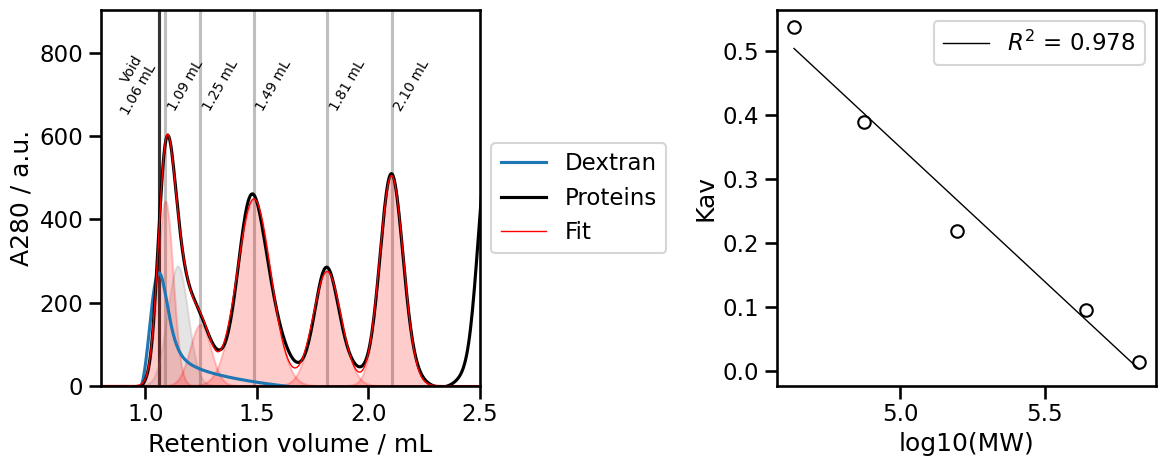

saving to:  /home/srgerb/scripts/cowboy/calibrations/2024-09-06_14-21-14-07-00_D1F-A2.dx_MWD1A_SG_240906_excl_void_agilent.json


In [25]:
#KF_ S200 100 uL injection
prot  = "/net/expdata/HPLC/GLaDOS/Calibrations/S200/20240906_calibration/D1F-A1/2024-09-06 14-16-29-07-00_D1F-A1.dx_MWD1A.CSV"
dex = "/net/expdata/HPLC/GLaDOS/Calibrations/S200/20240906_calibration/D1F-A2/2024-09-06 14-21-14-07-00_D1F-A2.dx_MWD1A.CSV"
S200mini_calibration_agilent_fitvoid( dex, prot, 0.65, "SG_240906")

VOID: 1.157 mL
(15,)
(2, 15)
[5.78247764e+02 4.46415946e+02 1.61759801e+02 2.32264234e+02
 4.29660972e+02 1.12635732e+00 1.25052336e+00 1.55592212e+00
 1.74814662e+00 1.85248720e+00 4.86748081e-02 8.95114404e-02
 9.99999991e-02 4.51588703e-02 9.60666457e-02]
[1.12635732 1.25052336 1.55592212 1.74814662 1.8524872 ]
calibrations/HAL9000_20240312_210324_01_D1F-H1.dx_DAD1A_KF_240312.png


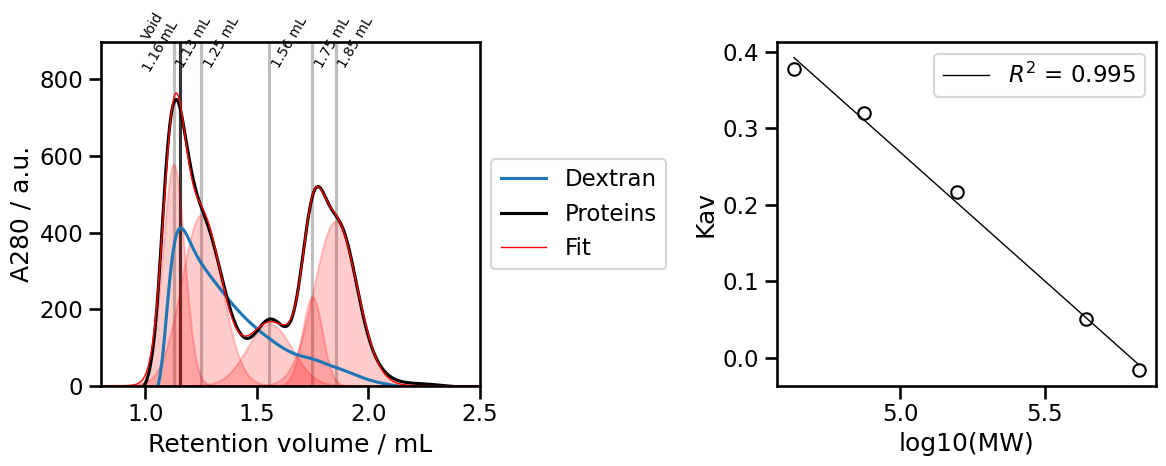

saving to:  /home/lmilles/3expdata/SEC/calibrations/HAL9000_20240312_210324_01_D1F-H1.dx_DAD1A_KF_240312_S200mini_agilent.json


In [27]:
dex  = '/net/expdata/HPLC/_HAL9000/Kfear/20240312/20240312 210324_01_D1F-H1/20240312 210324_01_D1F-H1.dx_DAD1A.CSV'
prot = '/net/expdata/HPLC/_HAL9000/Kfear/20240312/20240312 210938_02_D1F-H2/20240312 210938_02_D1F-H2.dx_DAD1A.CSV'
# S200mini_calibration_agilent_fitvoid( dex, prot, 0.65, "KF_240312",  )
S200mini_calibration_agilent( dex, prot, 0.65, "KF_240312",  )



VOID: 1.107 mL
(18,)
(2, 18)
[2.65994414e+02 7.50128858e+02 4.20061516e+02 3.89645584e+02
 3.97795705e+02 3.56352955e+02 1.10034536e+00 1.34451400e+00
 1.24291889e+00 1.57936085e+00 1.81378300e+00 2.11653006e+00
 4.81344229e-02 8.12994442e-02 5.38631607e-02 6.17630488e-02
 6.41405435e-02 6.86084071e-02]
[1.344514   1.24291889 1.57936085 1.813783   2.11653006]


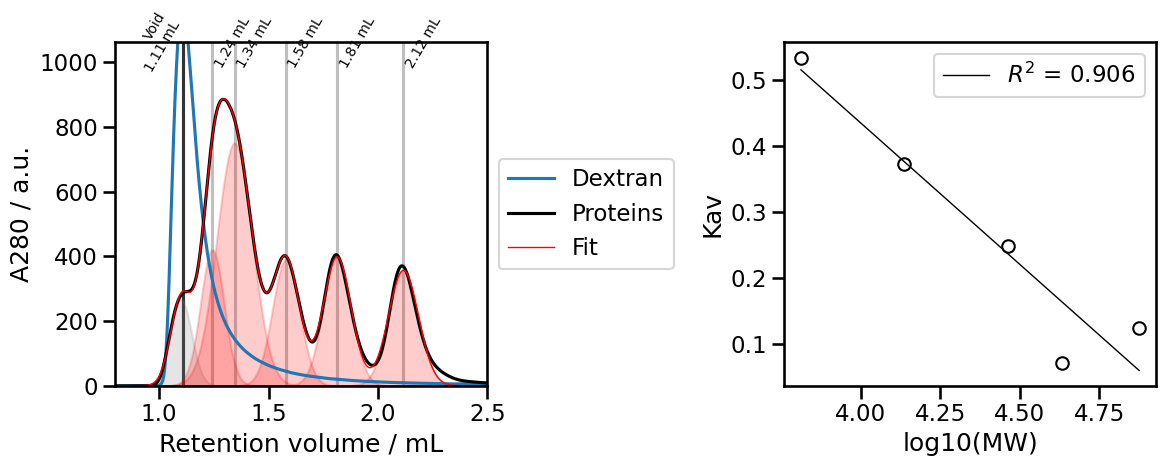

saving to:  /home/lmilles/3expdata/SEC/calibrations/HAL9000_20240418_141128_01_D1F-A1.dx_DAD1A_GG42_first_excl_void_agilent.json
VOID: 1.107 mL
(18,)
(2, 18)
[3.41969196e+01 7.61115510e+01 7.53139080e+01 4.72676145e+01
 4.96927704e+01 3.78945231e+01 1.06526469e+00 1.21372398e+00
 1.31448273e+00 1.53686988e+00 1.77565422e+00 2.08873756e+00
 4.35745840e-02 4.31482201e-02 6.42920826e-02 5.36234071e-02
 4.92160832e-02 6.09704363e-02]
[1.21372398 1.31448273 1.53686988 1.77565422 2.08873756]


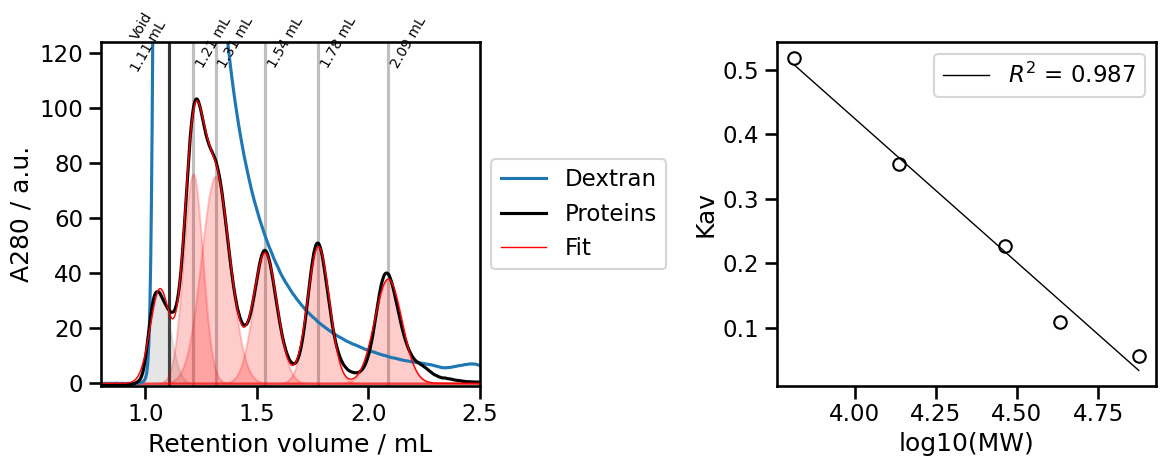

saving to:  /home/lmilles/3expdata/SEC/calibrations/HAL9000_20240418_141128_01_D1F-A1.dx_DAD1A_GG42_first_10_uL_excl_void_agilent.json


In [8]:
#GG42 first 100  uL injection
dex  = "/home/lmilles/3expdata/HPLC/2024_04_18_S75_cal/20240418 141128_01_D1F-A1/20240418 141128_01_D1F-A1.dx_DAD1A.CSV"
prot = "/home/lmilles/3expdata/HPLC/2024_04_18_S75_cal/20240418 141840_02_D1F-A2/20240418 141840_02_D1F-A2.dx_DAD1A.CSV"
S75mini_calibration_agilent_fitvoid( dex, prot, 0.65, "GG42_first" )

dex  = "/home/lmilles/3expdata/HPLC/2024_04_18_S75_cal/20240418 141128_01_D1F-A1/20240418 141128_01_D1F-A1.dx_DAD1A.CSV"
prot = "/home/lmilles/3expdata/HPLC/2024_04_18_S75_cal/20240418 142410_03_D1F-A2/20240418 142410_03_D1F-A2.dx_DAD1A.CSV"
S75mini_calibration_agilent_fitvoid( dex, prot, 0.65, "GG42_first_10_uL" )

 SET MANUAL VOID: 1.125
VOID: 1.125 mL
(15,)
(2, 15)
[4.65080535e+02 4.10597157e+02 1.59913291e+02 2.18461158e+02
 4.05926066e+02 1.12707023e+00 1.25819258e+00 1.56051677e+00
 1.75550985e+00 1.85946166e+00 5.02520868e-02 9.48974015e-02
 9.29852393e-02 4.89203136e-02 1.00000000e-01]
[1.12707023 1.25819258 1.56051677 1.75550985 1.85946166]
calibrations/HAL9000_20240514_202233_01_D2F-D1.dx_DAD1A_GG43_S200_first.png


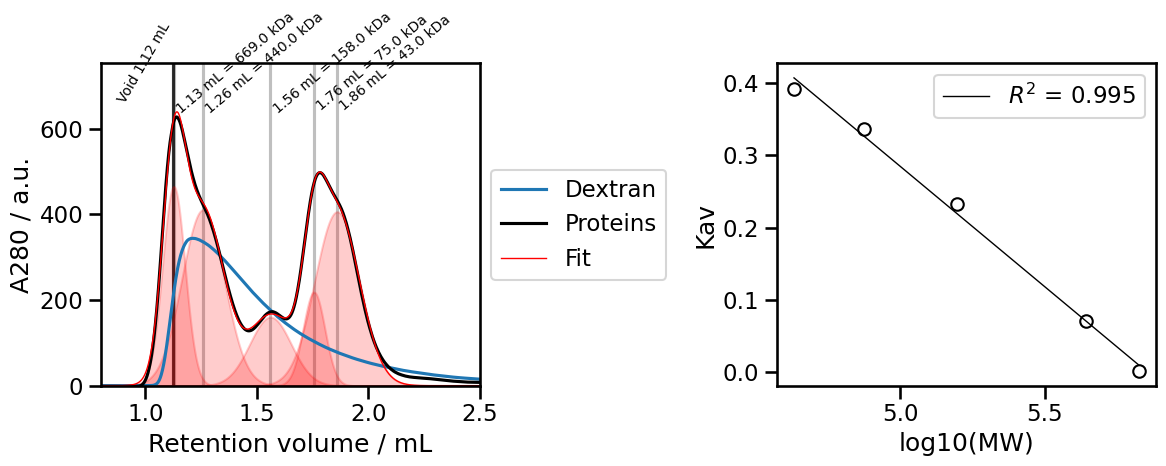

saving to:  /home/lmilles/3expdata/SEC/calibrations/HAL9000_20240514_202233_01_D2F-D1.dx_DAD1A_GG43_S200_first_S200mini_agilent.json
 SET MANUAL VOID: 1.08
VOID: 1.080 mL
(15,)
(2, 15)
[7.48069597e+01 3.98530436e+01 1.76891073e+01 4.39462617e+01
 3.89403604e+01 1.08136701e+00 1.22038925e+00 1.52776024e+00
 1.71922950e+00 1.83482397e+00 4.24363763e-02 8.90438663e-02
 7.51863154e-02 4.44712439e-02 7.54251424e-02]
[1.08136701 1.22038925 1.52776024 1.7192295  1.83482397]
calibrations/HAL9000_20240514_202233_01_D2F-D1.dx_DAD1A_GG43_s200_first_10_uL.png


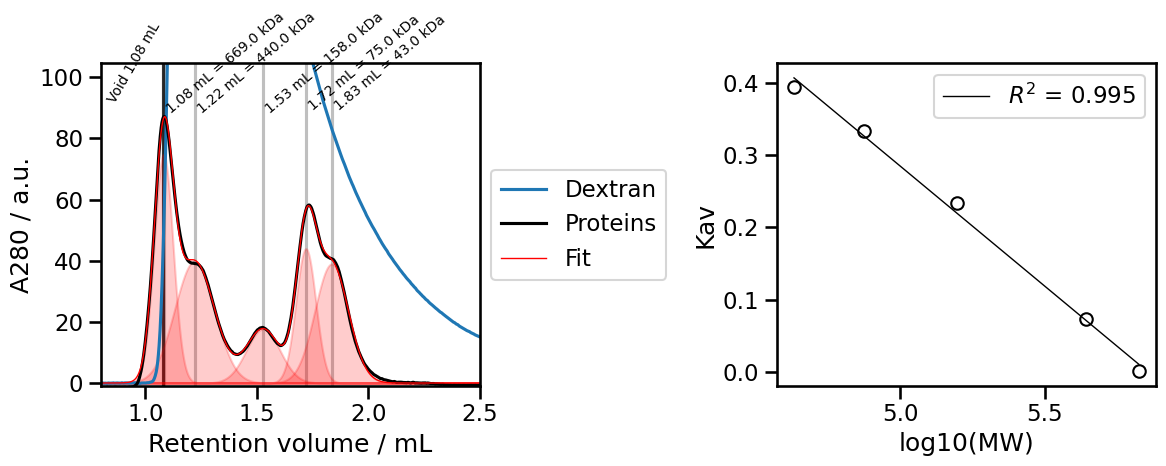

saving to:  /home/lmilles/3expdata/SEC/calibrations/HAL9000_20240514_202233_01_D2F-D1.dx_DAD1A_GG43_s200_first_10_uL_S200mini_agilent.json


In [18]:
def S200mini_calibration_agilent_manvoid(path_dextran, path_calib, flowrate, comment="", manvoid=0.0 ):
    '''
    chroma: folder path containing the blue-dextran and protein injections
    '''
    
    savename = 'calibrations/' + "HAL9000_" + dex.split('/')[-1].replace(".CSV", "").replace(" ", "_") + "_" + comment
    
    hmw_std = {
        'Thyroglobulin':669000,
        'Ferritin':440000,
        'Aldolase':158000,
        'Conalbumin':75000,
        'Ovalbumin':43000,
    }

    mw_std_list = [669000,
            440000,
            158000,
            75000,
            43000,]

    dextran = np.loadtxt(path_dextran, delimiter=",")
    dextran[:,0] = dextran[:,0] * flowrate

    v_dex, uv_dex = dextran[:,0] , dextran[:,1]
    void = v_dex[np.argmax(uv_dex)]

    if manvoid != 0.0:
        print(" SET MANUAL VOID:" , manvoid)
        void = float(manvoid)
    
    
    print ( f"VOID: {void:1.3f} mL")

    proteins = np.loadtxt(path_calib, delimiter=",")
    proteins[:,0] = proteins[:,0] * flowrate
    v_prot, uv_prot = proteins[:,0], proteins[:,1]

    # plt.plot(dextran[:,0], dextran[:,1])
    # plt.plot(proteins[:,0], proteins[:,1])
    # plt.show()

    # Get peaks by fitting to Gaussian functions
    peak_pos_guess = np.array([#void*0.95, #void peak 
                               1.22892861 , 1.33212932, 1.54220434, 1.78828965, 2.12824897,
                               #1.25, 1.35, 1.6, 1.80, 2.15
                              ])
    bounds = np.array( 
                       [ [0, 1100], ]   *len(peak_pos_guess) +     #scale
                       [ [1.0,2.6], ]   *len(peak_pos_guess) +     # mean
                       [ [1e-5, 1.0e-1], ] *len(peak_pos_guess) ,     # std
                         ).T
    p0 = np.hstack([np.array([50]*len(peak_pos_guess) ), np.array(peak_pos_guess) , np.array([0.01]*len(peak_pos_guess) )])
    print(p0.shape)
    print(bounds.shape)
    
    # popt= p0
    popt, pcov = curve_fit(gaussians, 
                           v_prot, 
                           uv_prot, 
                           p0=p0,
                           bounds=bounds ,
                           # maxfev=1e6
                          )
    print(popt)
    peaks = popt[len(peak_pos_guess):len(peak_pos_guess)+len(peak_pos_guess)]
    print(peaks)
    

    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].plot(v_dex, uv_dex, label='Dextran')
    ax[0].plot(v_prot, uv_prot, 'k-', label='Proteins')
    ax[0].plot(v_prot, gaussians(v_prot, *popt), 'r-', linewidth=1, label='Fit')
    
    for i in range(len(peak_pos_guess)):
        color='r'
        # if i == 0:
        #     color='gray'
        ax[0].fill_between(v_prot, gaussian(v_prot, *popt[i::len(peak_pos_guess)]), color=color, alpha=0.2)

        
    
    ax[0].set(xlim=[0.8,2.5])
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5) )#loc='best')
    ax[0].set(xlabel='Retention volume / mL', ylabel='A280 / a.u.',)# title=chroma.split('/')[-2])

    
    # Calibration curve
    Kav = (peaks - void) / (3-void)
    log10mw = np.log10(list(hmw_std.values()))
    slope, intercept, rvalue, pvalue, stderr = linregress(log10mw, Kav)
    xs = np.linspace(log10mw.min(), log10mw.max(), 100)
    
    for idx, peak in enumerate(peaks):
        ax[0].axvline(x=peak, color='gray', zorder=-10, alpha=0.5)
        dmw = mw_std_list[idx] / 1000.0
        ax[0].text(peak, 1.2*np.max(uv_prot), f"{peak:2.2f} mL = {dmw:2.1f} kDa", ha="left", va="center", rotation=40, fontsize=10)
    
    ax[0].axvline(x=void, color='k', zorder=-10, alpha=0.8)
    ax[0].text(void, 1.2*np.max(uv_prot), f"Void {void:2.2f} mL", ha="right", va="center", rotation=60, fontsize=10)
    
    ax[0].set_ylim( [-1.0, 1.2 * np.max(uv_prot) ] )


    ax[1].scatter(log10mw, Kav, color='white', edgecolor='k')
    ax[1].plot(xs, intercept + slope*xs, 'k-', linewidth=1, label=f'$R^2$ = {rvalue**2:.3f}')
    ax[1].legend(loc='best' ) #loc='best',
    ax[1].set(xlabel='log10(MW)', ylabel='Kav',)# title=chroma.split('/')[-2])
    plt.tight_layout()
    plt.savefig(savename + '.png', dpi=300)
    print(savename + '.png')
    plt.show()
    
    # Save calibration data.
    calibration_data = {
        'log10mw':log10mw.tolist(),
        'Kav':Kav.tolist(),
        'Vc':3,
        'Vo':void,
        'intercept':intercept,
        'slope':slope
    }
    
    print("saving to: " , os.path.abspath ( savename + f'_S200mini_agilent.json' )  )
    with open(savename + f'_S200mini_agilent.json' , 'w') as f:
        json.dump(calibration_data, f)

#GG43 first 100  uL injection
dex  = "/home/lmilles/3expdata/HPLC/2024_05_14_S200_cal/20240514 202233_01_D2F-D1/20240514 202233_01_D2F-D1.dx_DAD1A.CSV"
prot = "/home/lmilles/3expdata/HPLC/2024_05_14_S200_cal/20240514 202945_02_D2F-D2/20240514 202945_02_D2F-D2.dx_DAD1A.CSV"
S200mini_calibration_agilent_manvoid( dex, prot, 0.65, "GG43_S200_first" , manvoid=1.125 )

prot = "/home/lmilles/3expdata/HPLC/2024_05_14_S200_cal/20240514 203514_03_D2F-D2/20240514 203514_03_D2F-D2.dx_DAD1A.CSV"
S200mini_calibration_agilent_manvoid( dex, prot, 0.65, "GG43_s200_first_10_uL" , manvoid=1.08 )

VOID: 1.107 mL
(18,)
(2, 18)
[2.53614289e+02 5.61518228e+02 6.44119613e+02 4.42134611e+02
 4.01874908e+02 3.54889719e+02 1.10330997e+00 1.25425420e+00
 1.36037104e+00 1.57942053e+00 1.81815075e+00 2.12352141e+00
 4.85752453e-02 5.71828132e-02 7.37652407e-02 6.14496558e-02
 6.34406643e-02 6.87010602e-02]
[1.2542542  1.36037104 1.57942053 1.81815075 2.12352141]


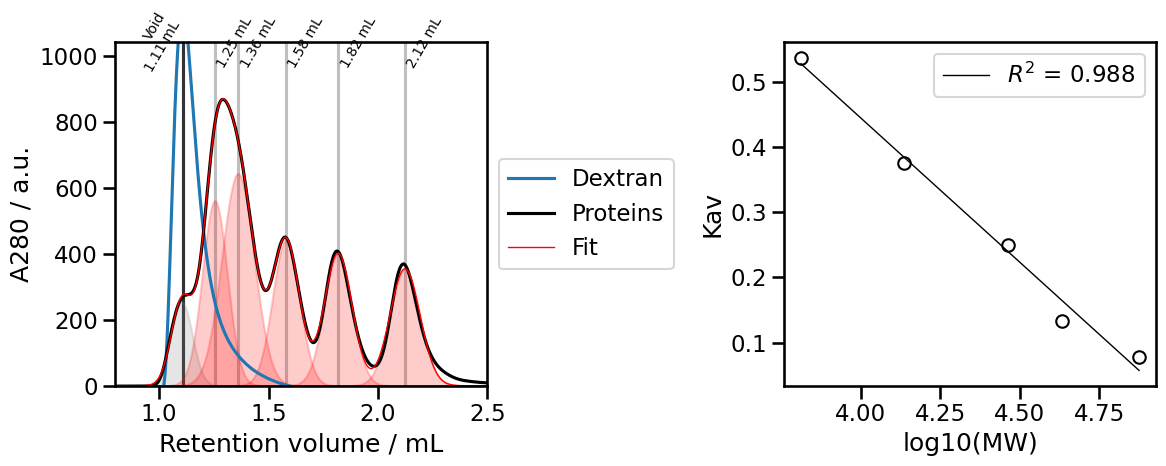

saving to:  /home/lmilles/3expdata/SEC/calibrations/HAL9000_2024-05-28_16-52-42-07-00-01.dx_DAD1A_GG44_first_excl_void_agilent.json
VOID: 1.107 mL
(18,)
(2, 18)
[3.05760224e+01 7.81865214e+01 6.90153287e+01 5.29221454e+01
 4.86660507e+01 3.64613465e+01 1.06499844e+00 1.21792330e+00
 1.31892437e+00 1.53463964e+00 1.78003058e+00 2.09868698e+00
 4.46209379e-02 4.45786600e-02 6.18415855e-02 5.17481220e-02
 4.98236324e-02 6.26543151e-02]
[1.2179233  1.31892437 1.53463964 1.78003058 2.09868698]


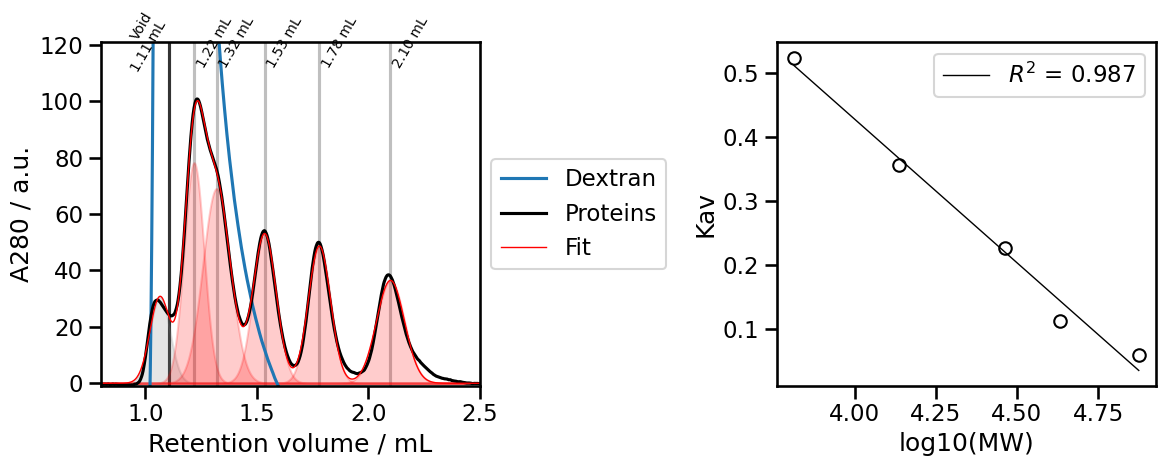

saving to:  /home/lmilles/3expdata/SEC/calibrations/HAL9000_2024-05-28_16-52-42-07-00-01.dx_DAD1A_GG44_first_10_uL_excl_void_agilent.json


In [19]:
#GG42 first 100  uL injection
dex  = "/home/lmilles/3expdata/HPLC/2024_05_28_S75cal_100_10/2024-05-28 16-52-42-07-00-01/2024-05-28 16-52-42-07-00-01.dx_DAD1A.CSV"
prot = "/home/lmilles/3expdata/HPLC/2024_05_28_S75cal_100_10/2024-05-28 16-59-52-07-00-02/2024-05-28 16-59-52-07-00-02.dx_DAD1A.CSV"
S75mini_calibration_agilent_fitvoid( dex, prot, 0.65, "GG44_first" )

prot = "/home/lmilles/3expdata/HPLC/2024_05_28_S75cal_100_10/2024-05-28 17-05-21-07-00-03/2024-05-28 17-05-21-07-00-03.dx_DAD1A.CSV"
S75mini_calibration_agilent_fitvoid( dex, prot, 0.65, "GG44_first_10_uL" )